In [20]:
%cd /home/donny/video_classification/

/home/donny/video_classification


In [2]:
import os
import logging
import json
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import tqdm.auto as tqdm
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, roc_auc_score
import wandb

from action_recognition.experiment.config import WandbConfig
from action_recognition.evaluate.evaluate_video import start_inferencing, fn2outfn, load_fine_annot
from action_recognition.datasets.video_annotation_dataset import read_annotations

logging.basicConfig(level=logging.INFO)


In [3]:
def get_group_ids(name):
    api = wandb.Api()
    group_runs = api.runs('donny/video_classification', {'group': name}, order='+config.split_by')
    ret = {}
    for run in group_runs:
        if run.state in ['finished'] and run.config['mix_clip'] == 0:
            ret[run.config['split_by']] = run.id
    return ret


In [23]:
video_paths = {
    'cage_0': 'data/mouse_video/20190814/V_20190814_134337_OC0_c0.mp4',  # 0
    'cage_1': 'data/mouse_video/20190906/V_20190906_123023_OC0_c0.mp4',  # 1
    'cage_2': 'data/mouse_video/20190906/V_20190906_123023_OC0_c1.mp4',  # 2
    'cage_3': 'data/mouse_video/20190917/V_20190917_124903_OC0_c0.mp4',  # 3
    'cage_4': 'data/mouse_video/20190917/V_20190917_124903_OC0_c2.mp4',  # 4
    'cage_5': 'data/mouse_video/20190917/V_20190917_124903_OC0_c3.mp4',  # 5
    'cage_6': 'data/mouse_video/20190919/V_20190919_134212_OC0_c0.mp4',  # 6
    'cage_7': 'data/mouse_video/20190919/V_20190919_134212_OC0_c1.mp4',  # 7
    'cage_8': 'data/mouse_video/20190919/V_20190919_134212_OC0_c2.mp4',  # 8
    'cage_9': 'data/mouse_video/20190919/V_20190919_134212_OC0_c3.mp4',  # 9
}
# model_id = '10dwpg3x'
# model_artifact_name = f"run_{model_id}_model"

run_group_names = [
    '10vid_I3D',
    # '5min_data_3D_balancevideo',
    # '5min_I3D_exclude2mouse_bc',  # bad
    # 'fpvid_I3D_bc',
    # 'fpvid_I3D_bv',  # bad
    # '5min_I3D_exclude2mousevd_bc',
    # '10vid_exclude2mousevd_bc',  # bad
    # 'fpvid_I3D_exclude2mousevd_bc',
    # '10vid_I3D_exclude2mousevd_nv_bc',  # bad
    # '5min_I3D_exclude2mousevd_nv_bc',
    # '10vid_I3D_nv_bc',  # bad
    # '5min_I3D_nv_bc',
    # '5min_res101_nv_bc_lr1e-4',
    # '10vid_I3D_bc_lr0.005',  # not finished
]
run_ids = [get_group_ids(n) for n in tqdm.tqdm(run_group_names)]
print(run_ids)
# fns = [[p] + [fn2outfn(p, f"run_{cg2id[split_name]}_model") for cg2id in run_ids] for split_name, p in video_paths.items()]
fns = [[p] + [fn2outfn(p, f"run_2rde0ddy_model") for cg2id in run_ids] for split_name, p in video_paths.items()]
# fns = [[p] + [fn2outfn(p, f"run_{cg2id['random']}_model") for cg2id in run_ids] for _, p in video_paths.items()]



[{'cage_0': '25v2nlrs', 'cage_1': '18yttzbt', 'cage_2': '3lrrwzr4', 'cage_3': '3oas0xfo', 'cage_4': '20udas4r', 'cage_5': '2lmxand7', 'cage_6': '2fzaldtp', 'cage_7': '3d9g5221', 'cage_8': 'xm3vgehq', 'cage_9': '16rxlt0t', 'random': '1wxilmf5'}]


In [5]:
scratch_dict = {
    "V_20190814_134337_OC0_c0": [5, 5, 3, 6, 6, 5, 3, 3, 4, 7, 4, 4, 3, 2, 6, 4, 5, 3, 5, 5, 5, 4, 5, 2, 5, 3, 2, 4, 4, 2, 4, 3, 3, 4, 5, 5],
    "V_20190906_123023_OC0_c0": [5, 4, 3, 8, 4, 7, 6, 8, 6, 5, 4, 7, 5, 1, 8, 3, 3, 3, 1, 2, 3, 1, 3, 2, 3, 7, 3, 1, 1, 3, 5, 7, 5, 4, 6, 5, 3, 4, 5, 4, 7, 5, 5, 5, 7, 6, 2, 2, 4, 3],
    "V_20190906_123023_OC0_c1": [6, 2, 3, 3, 9, 5, 3, 10, 9, 4, 6, 6, 2, 1, 7, 2, 6, 6, 7, 11],
    "V_20190917_124903_OC0_c0": [1, 2, 5, 2, 4, 2, 5, 3, 1, 4, 5, 3, 3, 3, 3, 2, 4, 5, 4, 2, 5, 13, 2, 5, 3, 2, 3, 2, 3, 4, 2, 3, 6, 2, 3],
    "V_20190917_124903_OC0_c2": [2, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 2, 4, 4, 2, 4, 3, 3, 6, 3, 4, 2, 3, 3, 3, 2, 5, 2, 3, 3, 3, 4, 3, 4, 5, 5, 2, 3, 4, 2, 2, 5, 2, 3, 4, 4, 6, 3, 4, 3, 3, 3, 3, 4, 3, 3, 6, 5, 6, 2, 3, 3, 3, 8, 6, 7, 5, 5, 1, 8, 10, 4, 4, 4, 6, 5, 5, 3, 4, 4, 3, 3, 3, 1, 7, 4, 3, 2, 5, 5, 4, 6, 3, 4, 7, 6, 4, 3, 4, 5, 8, 4, 7, 4, 5, 3, 3, 3, 5, 5, 3],
    "V_20190917_124903_OC0_c3": [5, 2, 5, 3, 4, 4, 2, 6, 3, 5, 5, 6, 6, 3, 3, 4, 6, 5, 4, 4, 4, 5, 5, 4, 4, 4, 5, 4, 3, 3, 6, 4, 6, 5, 5, 2, 6, 3, 3, 6, 5, 3, 7, 8, 4, 7, 7, 8, 6, 2, 4, 7, 6, 5, 2, 3, 3, 3, 3, 3, 5, 1, 2, 6, 4, 3, 4, 5, 1, 5, 6, 3, 8, 3, 5, 4, 5, 4, 5, 2, 8, 1, 3, 2, 6, 2, 7, 4, 5, 3, 2, 5, 4, 6, 4, 6, 2, 5, 9, 2, 3, 3, 3, 4, 5, 8, 5, 1, 6, 5, 3, 3, 2, 6, 5, 4, 3, 3, 6, 5, 5, 2, 9, 6, 5, 4, 4, 3, 3, 5],
    "V_20190919_134212_OC0_c0": [4, 4, 3, 6, 4, 3, 2, 3, 1, 5, 3, 2, 2, 2, 3, 1, 5, 5, 1, 2, 4, 2, 2, 3, 3, 4, 5, 4, 3, 3, 2, 2, 4, 5, 3, 3, 5, 4, 3, 2, 4, 3, 3, 3, 4, 4, 4, 4, 2, 3, 5, 5, 5, 5, 3, 6, 5, 4, 2, 3, 6, 5, 4, 4, 4, 5, 4, 2, 3, 3, 3, 10, 1, 2, 4, 4, 4, 8, 4, 1, 4, 3, 4, 5],
    "V_20190919_134212_OC0_c1": [4, 8, 4, 4, 4, 4, 4, 4, 3, 3, 4, 2, 4, 3, 4, 1, 3, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 1, 2, 4, 3, 4, 5, 5, 4, 2, 2, 2, 5, 1, 6, 4, 5, 4, 7, 7, 5, 5, 5, 3, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 4, 6, 4, 2, 3, 8, 5, 6, 5, 6, 5, 5, 4, 5, 3, 2, 5, 5, 4, 4, 5, 6, 6, 4, 6, 3, 4, 4, 5, 4, 4, 3, 5, 5, 1, 4, 4, 5, 4, 4, 4, 3, 3, 4, 5, 5, 5, 6, 4, 6, 5, 4, 5, 5, 8, 7, 5, 5, 4, 5, 5, 5],
    "V_20190919_134212_OC0_c2": [4, 3, 2, 3, 3, 3, 5, 2, 3, 3, 5, 5, 4, 3, 4, 4, 4, 4, 6, 4, 3, 4, 4, 2, 6, 5, 4, 4, 2, 5, 5, 5, 3, 9, 3, 7, 4, 4, 3, 5, 3, 3, 1, 4, 7, 3, 3, 2, 4, 5, 4, 3, 5, 6, 2, 5, 5, 4, 2, 5, 17, 5, 4, 5, 2, 4, 6, 4, 4, 6, 4, 4, 7, 8, 8, 8, 4, 4, 9, 5, 5, 6, 8, 3, 8, 4, 5, 5, 3, 5, 5, 5, 5, 4, 3, 5, 4, 4, 4, 5, 6, 6, 4, 3, 2, 4, 6, 4, 5, 3, 4, 5, 4, 4, 3, 6, 4, 2, 4, 4, 4, 4, 3],
    "V_20190919_134212_OC0_c3": [3, 2, 3, 4, 3, 3, 3, 2, 0, 5, 4, 3, 6, 2, 3, 3, 0, 4, 5, 6, 4, 7, 6, 4, 4, 3, 5, 4, 8, 6, 6, 3, 3, 3, 3, 3, 5, 6, 12, 5, 3, 5, 4, 3, 1, 4, 3, 4, 5, 3, 4, 4, 5, 8, 2, 4, 4, 5, 3, 7, 1, 3, 4, 7, 4, 5, 6, 6, 5, 6, 5, 5, 7, 4, 4, 1, 1, 1, 5, 4, 5, 5, 3, 4, 4, 3, 3, 4, 5, 4, 4, 4, 4, 3, 5, 3, 4, 3, 4, 3, 4, 4, 4, 5, 7, 4, 5, 5, 3, 2, 2, 3, 5, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 5, 4, 8, 3, 3, 2, 3, 5, 3, 5, 5, 3, 2, 4, 5, 5, 3, 5, 4, 1, 2, 2, 4, 4, 4, 3, 4, 4, 3, 4, 5, 4, 2, 3, 11, 12, 5, 7, 4, 4, 1, 2, 1, 1, 1],
}


len: 24551 name: data/mouse_video/20190814/V_20190814_134337_OC0_c0.mp4
              precision    recall  f1-score   support

 not scratch       1.00      0.98      0.99     23948
     scratch       0.50      0.81      0.62       603

    accuracy                           0.98     24551
   macro avg       0.75      0.90      0.80     24551
weighted avg       0.98      0.98      0.98     24551

[[23461   487]
 [  112   491]]
0.89696314790393
Scratches: 43 With gt: 35 Actually: 36


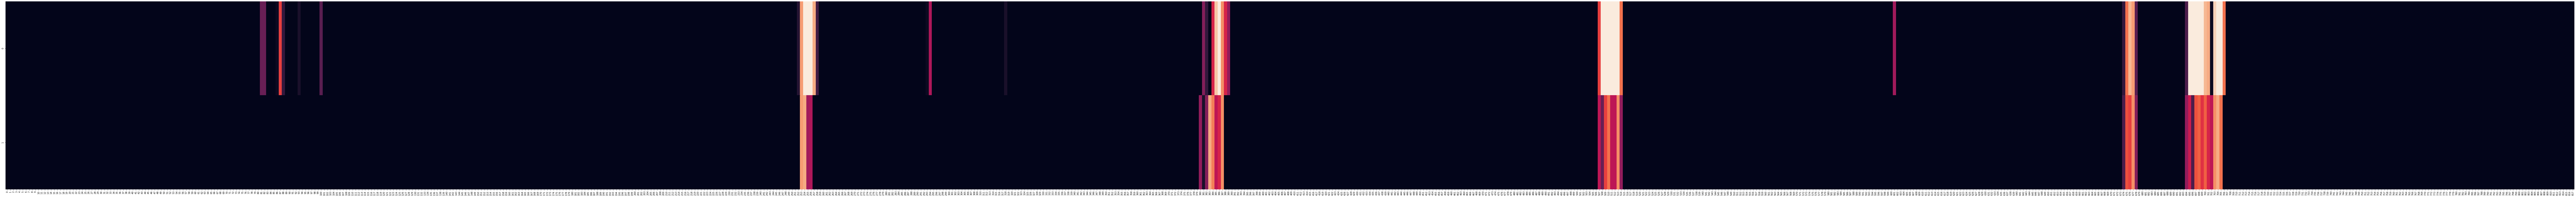

FileNotFoundError: [Errno 2] No such file or directory: 'output/run_25v2nlrs_model/V_20190906_123023_OC0_c0.mp4.pkl'

In [22]:
o1, o2, gts, weight = [], [], [], []
all_d, all_gt = [list() for _ in run_group_names], []
for fn, *outfns in fns:
    data = []
    for outfn in outfns:
        d = torch.stack(torch.load(outfn))[:, :2]
        d = torch.nn.functional.softmax(d, dim=1)  # [L, 2]
        d = torch.nn.functional.pad(d.T.view(2, 1, -1), (4, 0), 'constant', 0)
        d = torch.nn.functional.avg_pool1d(d, 5, stride=1).squeeze(1).T
        d = (d >= 0.8).float()  # [L, 2]
        data.append(d[:, :1])
    print("\nlen:", data[0].shape[0], "name:", fn)

    maxvidlen = max(d.shape[0] for d in data)
    minvidlen = min(d.shape[0] for d in data)
    if maxvidlen != minvidlen:
        wd = 15
        data = [d[-minvidlen:] for d in data]
    wd = 15

    # anno = load_annot(fn)
    anno = load_fine_annot(fn)
    gt = torch.zeros(data[0].shape[0], 1)
    for s, e in anno:
        gt[s - wd:e - wd] = 1

    for i, d in enumerate(data):
        print(classification_report(gt, d, target_names=["not scratch", "scratch"]))
        print(confusion_matrix(gt, d))
        print(roc_auc_score(gt, d))
        def count_scratch(ts, th=0.5):
            return torch.sum(torch.nn.functional.avg_pool1d(ts.T.view(1, 1, -1), 19, stride=19).squeeze(1).T >= th).item()
        o1.append(count_scratch(d, th=0.75))
        o2.append(count_scratch(gt))
        gts.append(len(scratch_dict[os.path.basename(fn).split('.')[0]]))
        print(
            "Scratches:", o1[-1],
            "With gt:", o2[-1],
            "Actually:", gts[-1],
        )
        weight.append(1.0 / len(d))
        all_d[i] += d[:, 0].tolist()
    all_gt += gt[:, 0].tolist()

    plt.figure(figsize=(200, 15))
    showtensor = torch.nn.functional.avg_pool1d(torch.cat(data + [gt], dim=1).T.view(len(data) + 1, 1, -1), 30).squeeze(1)
    sns.heatmap(showtensor, robust=False, cbar=False)
    plt.show()
print()
for name, ds in zip(run_group_names, all_d):
    print("showing:", name)
    print(confusion_matrix(all_gt, ds))
    print(classification_report(all_gt, ds, target_names=["not scratch", "scratch"]))
    print(roc_auc_score(all_gt, ds))

In [13]:
print(mean_absolute_error(gts, o1, sample_weight=weight))
print(mean_absolute_error(gts, o2, sample_weight=weight))

31.652401004515266
10.16765073744731


In [18]:
from action_recognition.evaluate.meters import AverageMeter
a1 = []
a2 = []
for vid, n_scratch in scratch_dict.items():
    vid_path = [v for v in video_paths.values() if vid in v][0]
    print(vid_path)
    anno = load_fine_annot(vid_path)
    print(len(anno), len([n for n in n_scratch if n > 0]))
    print(min(e - s for s, e in anno), max(e - s for s, e in anno))
    total_frame = sum(e - s for s, e in anno)
    total_scratch = sum(n_scratch)
    total_scratch = len(n_scratch)
    a2.append(total_frame / total_scratch)
print(np.mean(a2))

data/mouse_video/20190814/V_20190814_134337_OC0_c0.mp4
36 36
7 29
data/mouse_video/20190906/V_20190906_123023_OC0_c0.mp4
50 50
8 41
data/mouse_video/20190906/V_20190906_123023_OC0_c1.mp4
20 20
9 44
data/mouse_video/20190917/V_20190917_124903_OC0_c0.mp4
36 35
11 55
data/mouse_video/20190917/V_20190917_124903_OC0_c2.mp4
116 115
4 37
data/mouse_video/20190917/V_20190917_124903_OC0_c3.mp4
135 130
3 55
data/mouse_video/20190919/V_20190919_134212_OC0_c0.mp4
84 84
10 35
data/mouse_video/20190919/V_20190919_134212_OC0_c1.mp4
124 123
4 29
data/mouse_video/20190919/V_20190919_134212_OC0_c2.mp4
123 123
9 60
data/mouse_video/20190919/V_20190919_134212_OC0_c3.mp4
167 167
6 41
19.31052923186882


### 4.5 frames per scratch
### 19 frames per scratch cluster